## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [133]:
# autoreload for modules
%load_ext autoreload
%autoreload 2

# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
import pandas as pd # Used for simpler processing of data
import matplotlib.pyplot as plt
from PIL import Image

from utils.misc import load_data, load_data_AR

## Import Algorithms
from algs import NmfHyperEstimator, NmfL2Estimator

#Import preprocessing
from preprocessing import SaltNPepper, Gaussian, ImageNormalizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Dataset

### 1.0 Data Folder

In [134]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x 41 Dovermore staff 1312 Oct  6 14:04 CroppedYaleB
drwxr-xr-x 44 Dovermore staff 1408 Oct  6 14:04 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [135]:
# Load ORL dataset.
X_orl, Y_orl = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))

# Load Extended YaleB dataset.
X_yaleb, Y_yaleb = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yaleb.shape, Y_yaleb.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [136]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [137]:
#Demonstrate noisy Image
V_hat, Y_hat = load_data(root='data/ORL', reduce=3)
scaler = ImageNormalizer()

In [138]:
noise = SaltNPepper(p=0.1, r=0.4) 

V_snp = noise.fit_transform(V_hat)
V_snp = scaler.fit_transform(V_snp)

noise_g = Gaussian(mean=0, sigma=5) 
V_g = noise_g.fit_transform(V_hat)
V_g = scaler.fit_transform(V_g)

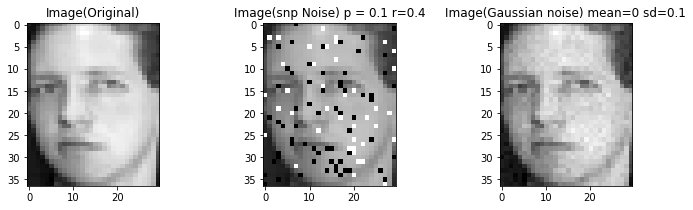

In [139]:
#Plot result.
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p = 0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0 sd=0.1')
plt.show()

In [140]:
#Image Reconstruction
# Hyper
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50, init="svd") # set n_components to num_classes.
H = nmf_hyper.fit_transform(V_snp)
W = nmf_hyper.components_

#Salt n Pepper
V_snp_reconstructed_hyper = W @ H
V_snp_reconstructedinv_hyper = scaler.invtransform(V_snp_reconstructed)


# L2
np.random.seed(0)
nmf_l2 = NmfL2Estimator(n_components=50, init="svd") # set n_components to num_classes.
H = nmf_l2.fit_transform(V_snp)
W = nmf_l2.components_

#Salt n Pepper
V_snp_reconstructed_l2 = W @ H
V_snp_reconstructedinv_l2 = scaler.invtransform(V_snp_reconstructed)

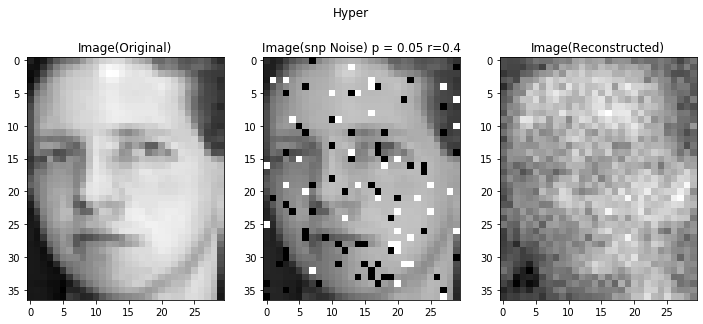

In [141]:
#Reconstruction (snp noise) using hyper
#img_size = [i//3 for i in (126, 144)] #CroppedYaleB
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p = 0.05 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Reconstructed)')
plt.suptitle("Hyper")
plt.show()

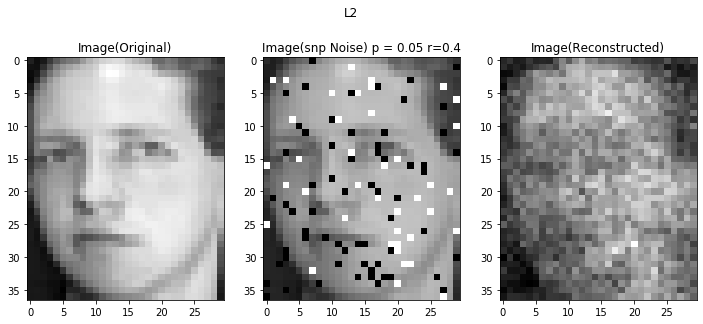

In [142]:
#Reconstruction (snp noise) using hyper
#img_size = [i//3 for i in (126, 144)] #CroppedYaleB
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p = 0.05 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_l2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Reconstructed)')
plt.suptitle("L2")
plt.show()

In [143]:
#Image Reconstruction
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50, init="svd") # set n_components to num_classes.
H = nmf_hyper.fit_transform(V_g)
W = nmf_hyper.components_

V_g_reconstructed_hyper = W @ H

np.random.seed(0)
nmf_l2 = NmfL2Estimator(n_components=50, init="svd") # set n_components to num_classes.
H = nmf_l2.fit_transform(V_g)
W = nmf_l2.components_

#Salt n Pepper
V_g_reconstructed_l2 = W @ H

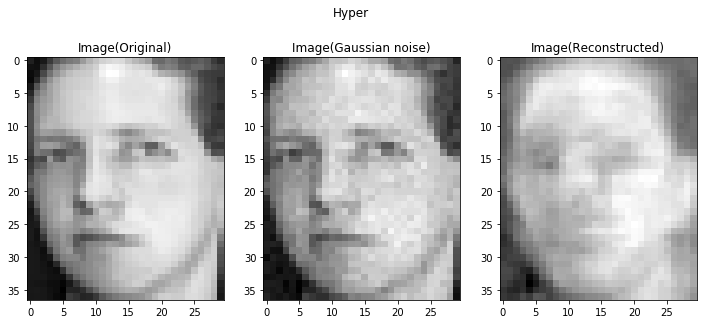

In [144]:
#Reconstruction of image (Gausian noise)
#img_size = [i//3 for i in (126, 144)] #CroppedYaleB
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise)')
plt.subplot(133)
plt.imshow(V_g_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Reconstructed)')
plt.suptitle("Hyper")
plt.show()

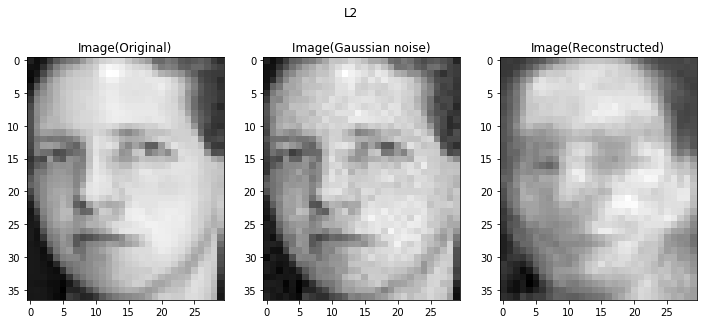

In [145]:
#Reconstruction of image (Gausian noise)
#img_size = [i//3 for i in (126, 144)] #CroppedYaleB
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise)')
plt.subplot(133)
plt.imshow(V_g_reconstructed_l2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Reconstructed)')
plt.suptitle("L2")
plt.show()

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [146]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


In [147]:
from sklearn.decomposition import NMF


# Transpose X for correct shape
class ModifiedNMF:
    def __init__(self, *args, **kwargs):
        self.nmf = NMF(*args, **kwargs)
    
    def fit(self, X, *args, **kwargs):
        X = X.T
        self.nmf.fit(X, *args, **kwargs)
        return self
    
    def transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.transform(X, *args, **kwargs).T
    
    def fit_transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.fit_transform(X, *args, **kwargs).T
    
    @property
    def components_(self):
        return self.nmf.components_.T

In [159]:
import textwrap
import itertools


def make_grid_alg_kwargs(alg, **kwargs):
    keys = []
    values_list = []
    for key, values in kwargs.items():
        keys.append(key)
        values_list.append(values)
        
    grid_kwargs = []
    for value_product in list(itertools.product(*values_list)):
        kwargs = {}
        grid_kwargs.append(kwargs)
        for key, value in zip(keys, value_product):
            kwargs[key] = value
    alg_kwargs_pairs = [(alg, kwargs) for kwargs in grid_kwargs]
    return alg_kwargs_pairs


def indent(text, amount, ch=' '):
        return textwrap.indent(text, amount * ch)


def rre_score(model, X, Y, Y_pred, W, H):
    return np.linalg.norm(X - W.dot(H)) / np.linalg.norm(X)


def acc_score(model, X, Y, Y_pred, W, H):
    return accuracy_score(Y, Y_pred)


def nmi_score(model, X, Y, Y_pred, W, H):
    return normalized_mutual_info_score(Y, Y_pred)


def benchmark(X, Y, scaler,
              alg_kwargs_pairs, all_n_components, # algs configs
              noise_kwargs_pairs, # noise configs
              metrics, metrics_names=None, # evaluations
              n_trials=5, pc_sample=0.9): # sampling configs
    """Benchmark algs and output long form evaluation results"""
    # Prepare column names in data frame
    if metrics_names is None:
        metrics_names = [m.__name__ for m in metrics]
    
    evaluations = pd.DataFrame(columns = 
                               ["alg", "n_components", "kwargs", "noise_id", "noise_level", 
                                "ratio", "trial_id"] + metrics_names)
    if isinstance(all_n_components, int):
        all_n_components = [all_n_components]
        
    # Prepare salt and pepper
    noises = []
    for i, (noise_alg, noise_kwargs) in enumerate(noise_kwargs_pairs):
        noise = noise_alg(**noise_kwargs)
        noises.append([noise, {"noise_id": i, **noise_kwargs}])
        
    # Prepare subseting
    subset_idxs = []
    for n in range(n_trials):
        subset_idxs.append(np.random.choice(range(X.shape[1]), size=int(0.9 * X.shape[1]), replace=False))
    # preprocess data
    X = scaler.fit_transform(X)
        
    for noise, noise_kwargs in noises:
        # Noise outer loop to keep it consistent between runs
        X_noise = noise.fit_transform(X)
        print(indent("Noise: " + str(noise_kwargs), 0))
        for i, subset_idx in enumerate(subset_idxs):
            print(indent("Trail: " + str(i), 4))
            X_subset = X_noise[:, subset_idx]
            Y_subset = Y[subset_idx]
            for alg in alg_kwargs_pairs:
                # Separate kwargs if additional kwargs are provided
                try:
                    if len(alg) == 2:
                        alg, alg_kwargs = alg
                except:
                    alg_kwargs = {}
                    
                print(indent("Alg: " + alg.__name__ + " " + str(alg_kwargs), 8))
                for k in all_n_components:
                    row = {**noise_kwargs}
                    row.update(
                        {"alg": alg.__name__, "n_components": k, "kwargs": alg_kwargs, "trial_id": i})
                    model = alg(n_components=k, **alg_kwargs)
                    H = model.fit_transform(X_subset)
                    W = model.components_
                    # print(model.__class__, "W", W.shape, "H", H.shape)
                    # Y_pred = assign_cluster_label(H.T, Y_subset)
                    Y_pred = assign_cluster_label(H.T, Y_subset)
                    
                    for metric, name in zip(metrics, metrics_names):
                        row[name] = metric(model, X_subset, Y_subset, Y_pred, W, H)
                    evaluations = evaluations.append(row, ignore_index=True)
    return evaluations


X, Y, scaler = X_orl, Y_orl, ImageNormalizer()
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]
all_n_components = range(10, 50, 20)

# # salt and pepper noise # Uncomment to use
# noise_alg = SaltNPepper
# noise_levels = np.arange(0.1, 0.5, 0.1)
# ratios = np.arange(0.0, 1, 0.5)
# noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

# Gaussian noise
noise_alg = Gaussian
means = [0, 1]
sigmas = list(range(1, 20, 5))
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, mean=means, sigma=sigmas)


ratios = np.arange(0.0, 1, 0.5)

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3
pc_sample = 0.4

evaluations = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.1, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}


KeyboardInterrupt: 

In [61]:
# Simple check for scores
(evaluations.query("n_components == 30 and ratio==1 and ratio==0.5")
 .sort_values(["trial_id", "acc_score"]))

,alg,n_components,kwargs,noise_id,noise_level,ratio,trial_id,rre,acc_score,nmi_score


Text(0, 0.5, 'Normalised Mutual Info Score')

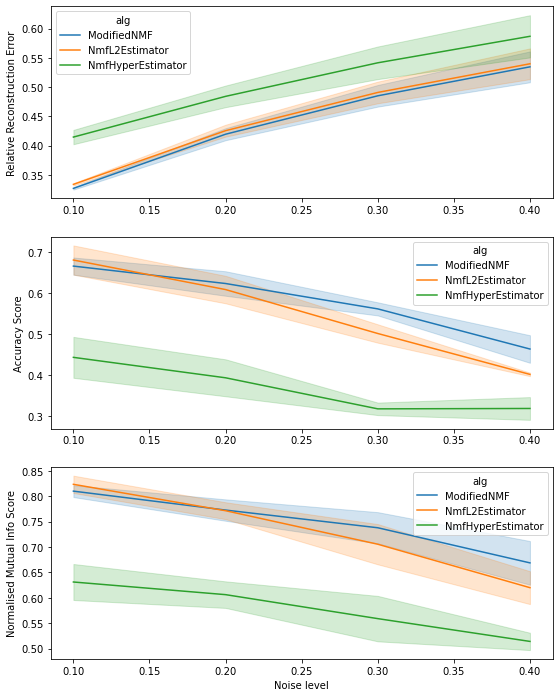

In [62]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=30
import seaborn as sns

fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="noise_level",
    y="rre",
    hue="alg",
    #size="n_components",
    #style="ratio",
    data=evaluations.query("n_components == 30"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")

ax = fig.add_subplot(312)
sns.lineplot(
    x="noise_level",
    y="acc_score",
    hue="alg",
    #size="n_components",
    #style="ratio",
    data=evaluations.query("n_components == 30 and ratio==0.5"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")

ax = fig.add_subplot(313)
sns.lineplot(
    x="noise_level",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    #style="ratio",
    data=evaluations.query("n_components == 30"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")

Text(0, 0.5, 'Relative Reconstruction Error')

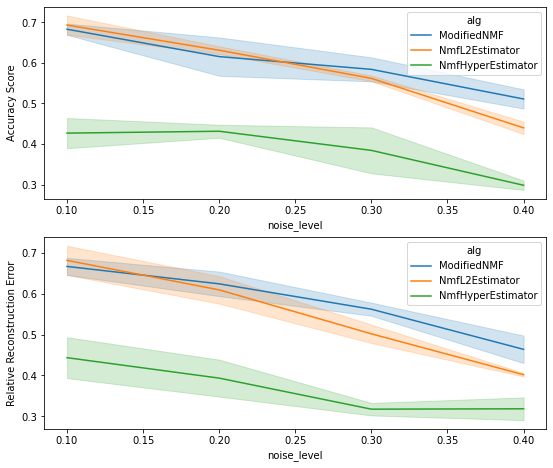

In [63]:
# Measuring RRE, Accuracy and NMI scores for n_components=30
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="noise_level",
    y="acc_score",
    hue="alg",
    #size="n_components",
    #style="ratio",
    data=evaluations.query("n_components == 30 and ratio==0"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_ylabel("Accuracy Score")

ax = fig.add_subplot(312)
sns.lineplot(
    x="noise_level",
    y="acc_score",
    hue="alg",
    #size="n_components",
    #style="ratio",
    data=evaluations.query("n_components == 30 and ratio==0.5"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_ylabel("Relative Reconstruction Error")